In [1]:
from platform import python_version
print(python_version())

3.9.12


## Importing Required Libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from IPython.display import display
from IPython.display import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_path = r"F:\Datasets\Alzheimer_s Dataset\train"
test_path = r"F:\Datasets\Alzheimer_s Dataset\test"

In [5]:
train_data = image_dataset_from_directory(directory=train_path, labels='inferred', label_mode='categorical', 
                                          color_mode='rgb', batch_size=128, image_size=(176, 208),
                                          shuffle=True, seed=77, validation_split=0.2, subset='training')

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [6]:
validation_data = image_dataset_from_directory(directory=train_path, labels='inferred', label_mode='categorical', 
                                          color_mode='rgb', batch_size=128, image_size=(176, 208),
                                          shuffle=True, seed=77, validation_split=0.2, subset='validation')

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [7]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 176, 208, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

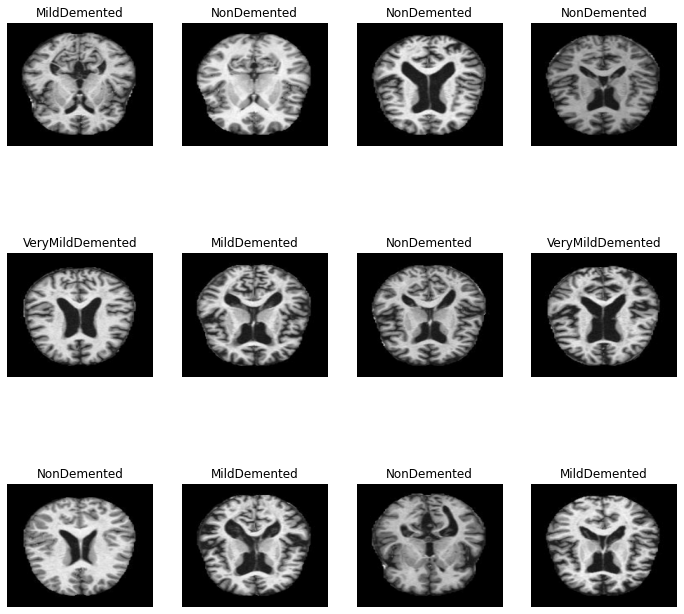

In [8]:
plt.figure(figsize=(12,12))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(train_data.class_names[np.argmax(labels[i])])
        plt.axis("off")

In [9]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model

In [10]:
feature_extractor = Sequential()

feature_extractor.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(176,208,3)))
feature_extractor.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(GlobalAveragePooling2D())

x = feature_extractor.output  
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

# Make a new model combining both feature extractor and x
model = Model(inputs=feature_extractor.input, outputs=output, name='Alzheimer_Detection_with_CW')
optimizer_ = tf.keras.optimizers.Adam(lr=0.01)

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer_, 
              metrics=[tf.keras.metrics.AUC(name='auc_score')])

model.summary()

Model: "Alzheimer_Detection_with_CW"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 176, 208, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 176, 208, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 103, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 87,

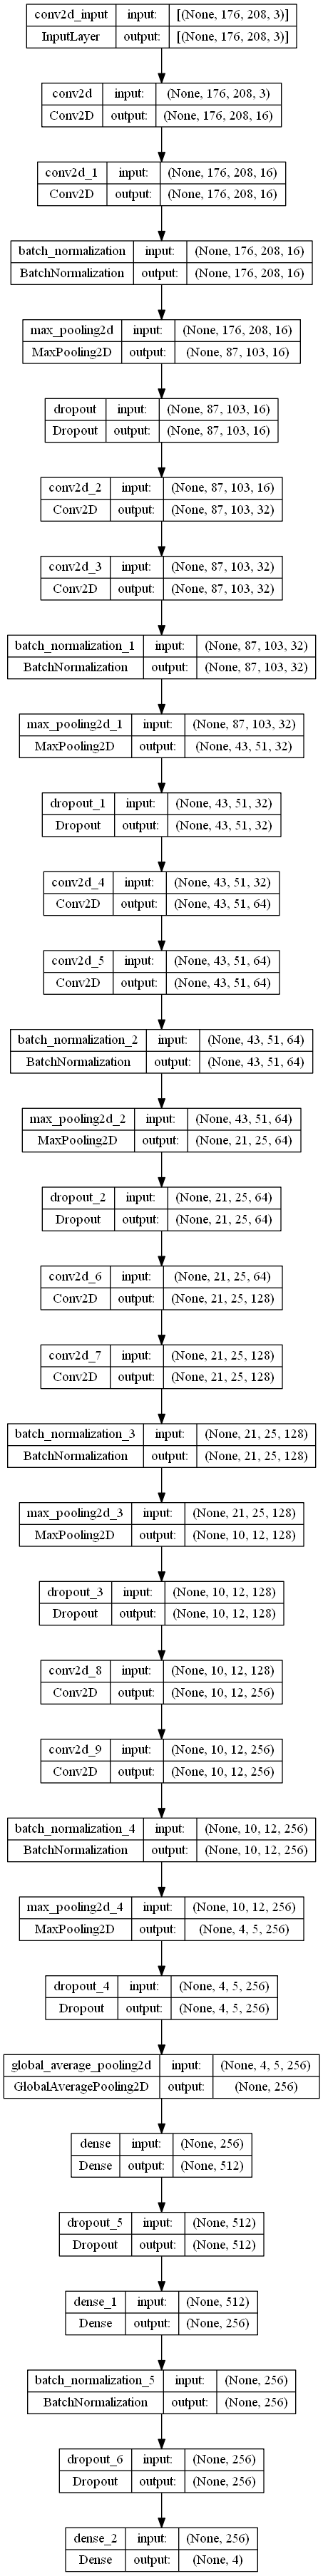

In [11]:
plot_model(model, to_file='Alzheimer_Detection_with_CW.png', show_shapes=True, show_layer_names=True)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from datetime import datetime 
from sklearn.utils import class_weight

In [13]:
len(train_data)

33

In [14]:
y_train = []
for i in tqdm(range(33)):
    for j in list(train_data)[i][1]:
        y_train.append(j.numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:09<00:00,  2.11s/it]


In [15]:
y_train = np.array(y_train)
y_train = np.argmax(y_train, axis=1)
y_train

array([2, 0, 3, ..., 2, 2, 3], dtype=int64)

In [16]:
np.unique(y_train)

array([0, 1, 2, 3], dtype=int64)

In [17]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(4)}
class_weights

{0: 1.81604609929078,
 1: 18.62272727272727,
 2: 0.48773809523809525,
 3: 0.7432873730043541}

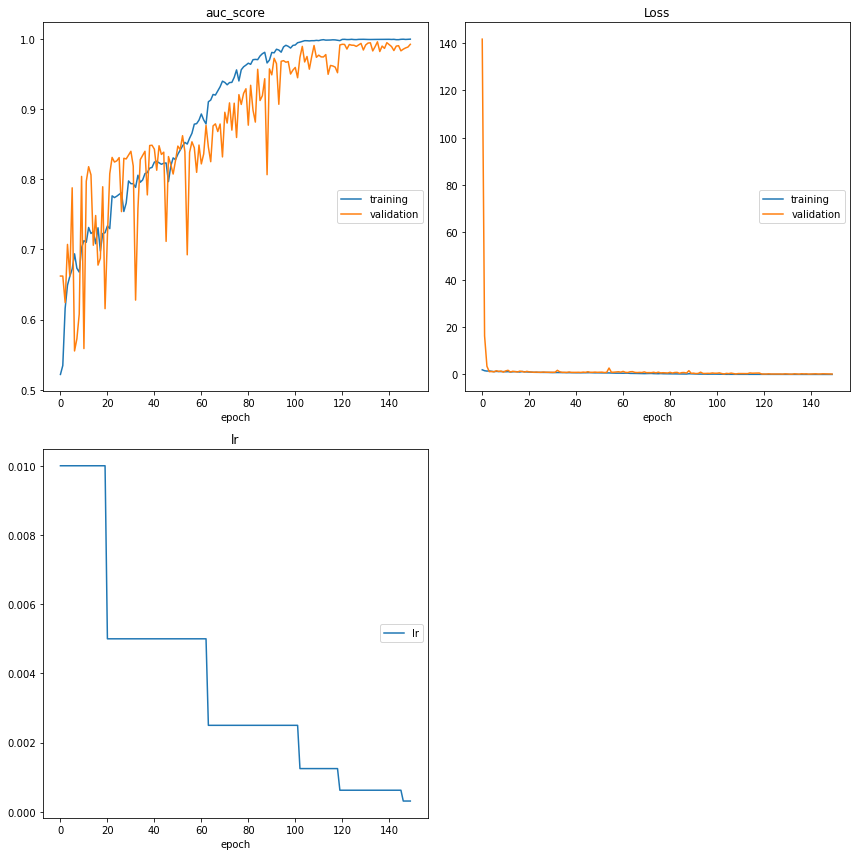

auc_score
	training         	 (min:    0.522, max:    1.000, cur:    1.000)
	validation       	 (min:    0.555, max:    0.996, cur:    0.992)
Loss
	training         	 (min:    0.019, max:    1.981, cur:    0.019)
	validation       	 (min:    0.122, max:  141.616, cur:    0.186)
lr
	lr               	 (min:    0.000, max:    0.010, cur:    0.000)
33/33 [==============================] - 5s 159ms/step - loss: 0.0189 - auc_score: 0.9998 - val_loss: 0.1858 - val_auc_score: 0.9925 - lr: 3.1250e-04
Training completed in 0:13:24.981334


In [18]:
checkpointer = ModelCheckpoint(filepath = 'saved_checkpoints/Alzheimer_Detection_CNN_with_CW/checkpoint', verbose=1, save_best_only=True, 
                               monitor='val_loss', mode='min', save_weights_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)


reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=10, verbose=1, min_lr=0.00001)


start = datetime.now()

trained_model = model.fit(train_data, epochs=150, validation_data=validation_data, class_weight=class_weights,
          callbacks=[checkpointer, early_stop, reduce_lr_on_plateau, tensorboard, PlotLossesKeras()], verbose=1)


duration = datetime.now() - start

print("Training completed in {}".format(duration))

In [18]:
model.load_weights('saved_checkpoints/Alzheimer_Detection_CNN_with_CW/checkpoint')

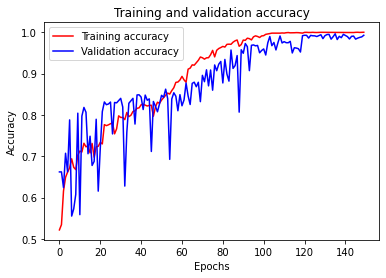

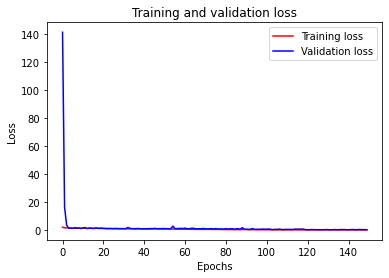

In [20]:
import matplotlib.pyplot as plt

auc_score = trained_model.history['auc_score']
val_auc_score = trained_model.history['val_auc_score']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = list(range(0,150))

plt.plot(epochs, auc_score, 'r', label='Training accuracy')
plt.plot(epochs, val_auc_score, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay

In [20]:
test_data = image_dataset_from_directory(directory=test_path, labels='inferred', label_mode='categorical', 
                                          color_mode='rgb', batch_size=128, image_size=(176, 208),
                                          shuffle=False, seed=77)

Found 1279 files belonging to 4 classes.


In [21]:
val_loss, val_auc_score = model.evaluate(validation_data)
print("val_loss = {} and val_auc_score = {}".format(val_loss, val_auc_score))

8/8 [==============================] - 20s 102ms/step - loss: 0.1216 - auc_score: 0.9960
val_loss = 0.12156931310892105 and val_auc_score = 0.9960072636604309


In [22]:
test_loss, test_auc_score = model.evaluate(test_data)
print("Test_loss = {} and Test_auc_score = {}".format(test_loss, test_auc_score))

10/10 [==============================] - 4s 321ms/step - loss: 1.7032 - auc_score: 0.8370
Test_loss = 1.703184962272644 and Test_auc_score = 0.8370425701141357


In [23]:
test_predictions =  model.predict(test_data) 

10/10 [==============================] - 1s 111ms/step


In [24]:
test_predictions[0]

array([1.4124501e-01, 8.8200264e-04, 1.6155042e-04, 8.5771143e-01],
      dtype=float32)

In [25]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 176, 208, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [26]:
list(test_data)[1][1]

<tf.Tensor: shape=(128, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],


In [27]:
len(list(test_data)) #this is the no. of batches.

10

In [28]:
test_predictions[1278]

array([1.0480905e-02, 3.5704585e-04, 1.1719114e-03, 9.8799020e-01],
      dtype=float32)

In [29]:
test_predictions = np.argmax(test_predictions, axis=1)
test_predictions

array([3, 0, 0, ..., 3, 3, 3], dtype=int64)

In [30]:
y_test = []
for i in tqdm(range(10)):
    for j in list(test_data)[i][1]:
        y_test.append(j.numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


In [31]:
y_test = np.array(y_test)
y_test.shape

(1279, 4)

In [32]:
y_test = np.argmax(y_test, axis=1)
y_test

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [33]:
mapping_dict = {"Mild Demented":0, "Moderate Demented":1, "Non Demented":2, "Very Mild Demented":3}
target_classes=[]

for i in mapping_dict.keys():
    target_classes.append(i)

In [34]:
#test data's metrics

print(confusion_matrix(y_test, test_predictions))
print('\n')
macroF1 = precision_recall_fscore_support(y_test, test_predictions, average='macro')
microF1 = precision_recall_fscore_support(y_test, test_predictions, average='micro')
print("Marco Precision Recall & F1 Scores: {}".format(macroF1))
print("Micro Precision Recall & F1 Scores: {}".format(microF1))
print("\n")
print(classification_report(y_test, test_predictions, target_names=target_classes))

[[ 67   0  24  88]
 [  0   2   0  10]
 [ 27   0 380 233]
 [ 15   0  65 368]]


Marco Precision Recall & F1 Scores: (0.7378449553010069, 0.48903672851822294, 0.5194920173572658, None)
Micro Precision Recall & F1 Scores: (0.6387802971071149, 0.6387802971071149, 0.6387802971071149, None)


                    precision    recall  f1-score   support

     Mild Demented       0.61      0.37      0.47       179
 Moderate Demented       1.00      0.17      0.29        12
      Non Demented       0.81      0.59      0.69       640
Very Mild Demented       0.53      0.82      0.64       448

          accuracy                           0.64      1279
         macro avg       0.74      0.49      0.52      1279
      weighted avg       0.69      0.64      0.64      1279



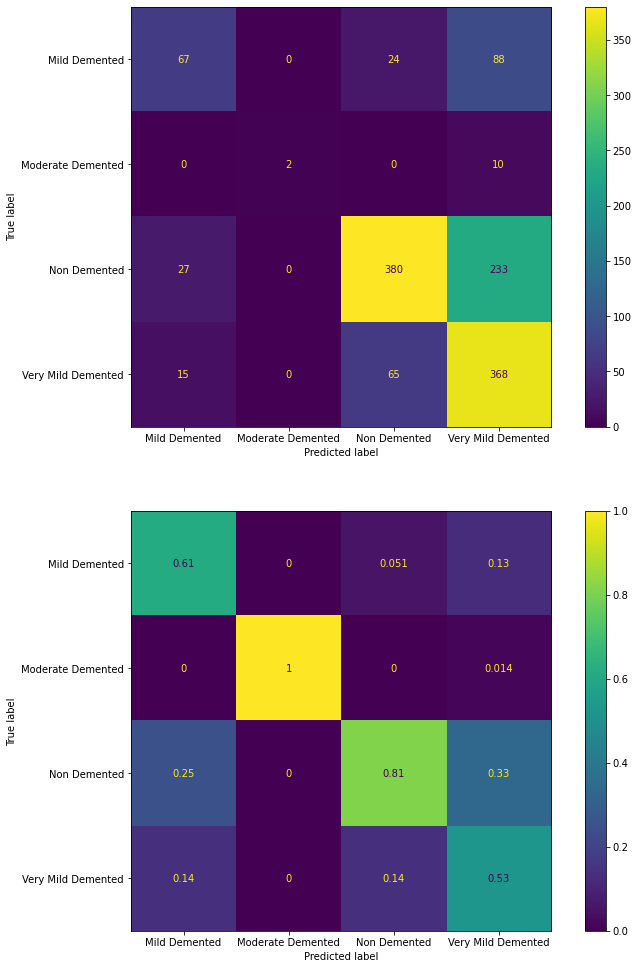

In [35]:
#plotting the confusion matrix for validation data:

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,17))
cm_plot_1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=target_classes)
cm_plot_2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions, normalize='pred'), display_labels=target_classes)
cm_plot_1.plot(ax=ax1)
cm_plot_2.plot(ax=ax2)

plt.show()